<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/Generate_Music_using_LSTM_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 모델로 작곡하기
- 내용 출처
1. https://github.com/KerasKorea/KEKOxTutorial.git
2. https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5
3. https://www.tensorflow.org/tutorials/audio/music_generation
- 목표: Keras 라이브러리를 사용하여 파이썬으로 순환 신경망을 사용하여 음악 작곡


## 01. 순환 신경망(RNN, Recurrent Neural Networks)
- 순차적인 정보를 이용하는 인공 신경망의 종류 중 하나
- 시퀀스의 모든 단일 요소에 대해 동일한 기능을 수행하기 때문이고, 각 결과는 이전 연산에 따라 달라지기 때문에 순환이라고 한다

## 02. LSTM
- 순환신경망의 하나로 경사 하강을 통해 효율적으로 학습
- 게이트 메커니즘을 사용하여 장기 패턴 인식 / 인코딩 가능
- 음악 및 텍스트 생성의 경우와 같이 네트워크가 오랜 시간 동안 정보를 기억해야 하는 문제를 해결하는데 매우 유용함

## 03. Music21
- 컴퓨터를 활용하는 음악학에 사용되는 Python 툴킷
- 음악 예시 제작, 음악 공부 가능
- MIDI 파일의 음악 표기법을 습득할 수 있는 간단한 인터페이스 제공
- 노트 및 코드(chord) 객체를 만들어 쉽게 MIDI 파일 제작 가능
- 해당 노트에서는 Music21을 데이터 세트의 콘텐츠를 추출하고, 음악 표기법으로부터 인공 신경망을 통해 결과값을 얻는데 사용

## 04. 학습

### 1. 설정

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [2]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 5.1 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=b0dc28e9bcd349cb6578943b584defd2f3a271fa7c5465c3e9d56d7c968aaad2
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


### 2. 라이브러리 추가

In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
_SAMPLING_RATE = 16000

### 3. Maestro 데이터 세트 다운로드

In [6]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 1s 0us/step


In [7]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### 4. MIDI 파일 처리

In [8]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--5.midi


In [9]:
# 샘플 MIDI 파일에 대한 PrettyMIDI 개체 생성
pm = pretty_midi.PrettyMIDI(sample_file)

In [10]:
# 음성 파일 재생 함수 정의
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [11]:
# 샘플 파일 재생
display_audio(pm)

In [12]:
# 재생한 음악에 사용된 악기 출력
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [13]:
# 노트(음표) 출력
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=33, note_name=A1, duration=0.8021
1: pitch=45, note_name=A2, duration=0.9818
2: pitch=57, note_name=A3, duration=1.9219
3: pitch=44, note_name=G#2, duration=1.0221
4: pitch=32, note_name=G#1, duration=1.0742
5: pitch=56, note_name=G#3, duration=2.3997
6: pitch=25, note_name=C#1, duration=4.3372
7: pitch=49, note_name=C#3, duration=4.6432
8: pitch=37, note_name=C#2, duration=4.7083
9: pitch=61, note_name=C#4, duration=0.1615


In [15]:
# 음표 추출 함수 정의
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start
  
  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [16]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,57,0.954427,2.876302,0.000000,1.921875
1,45,0.959635,1.941406,0.005208,0.981771
2,33,0.960938,1.763021,0.001302,0.802083
3,44,2.885417,3.907552,1.924479,1.022135
4,56,2.885417,5.285156,0.000000,2.399740


In [17]:
# 숫자 음높이 값에서 음표 이름으로 변환
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A3', 'A2', 'A1', 'G#2', 'G#3', 'G#1', 'C#3', 'C#2', 'C#1', 'C#5'],
      dtype='<U3')

In [18]:
# 악곡 시각화 함수 정의
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

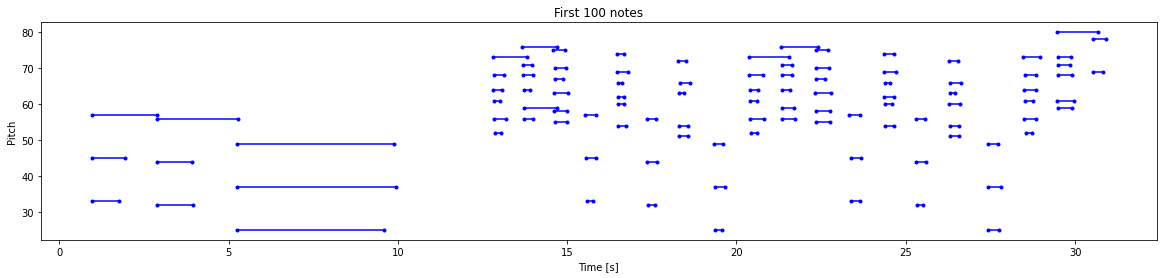

In [19]:
# 첫 100개의 음표 그래프로 시각화
plot_piano_roll(raw_notes, count=100)

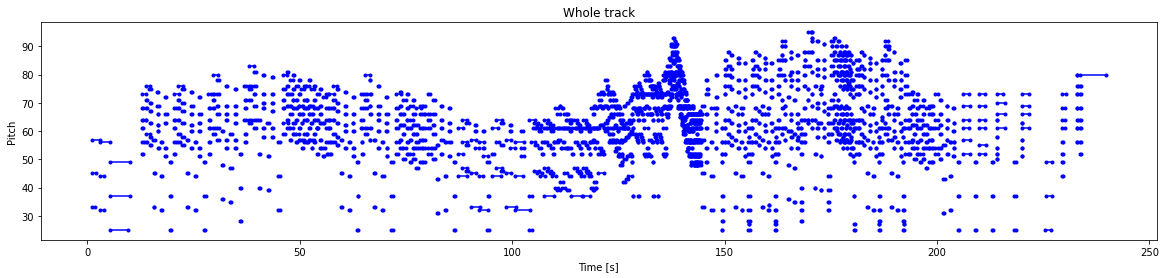

In [20]:
# 전체 트랙에 대한 음표 그래프로 시각화
plot_piano_roll(raw_notes)

In [21]:
# 각 음표 변수의 분포 확인 함수 정의
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

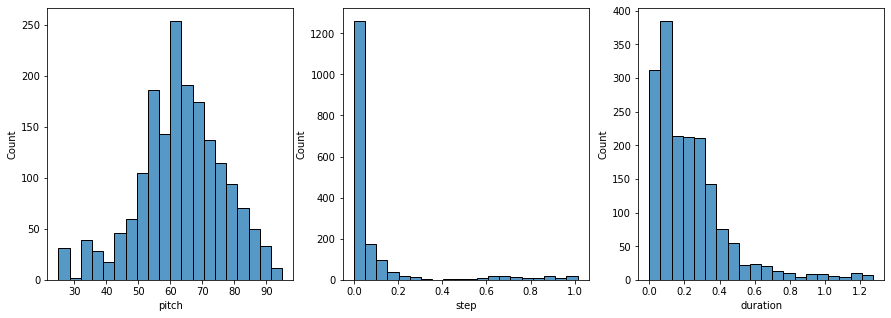

In [22]:
plot_distributions(raw_notes)

### 5. MIDI 파일 생성

In [23]:
# 음표 목록에서 자신의 MIDI 파일을 생성하기
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [24]:
# MIDI 파일 생성
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [25]:
# 생성된 MIDI 파일을 재생하여 차이점 확인
display_audio(example_pm)

### 6. 훈련 데이터 세트 생성

In [26]:
# MIDI 파일에서 음표를 추출하여 훈련 데이터 세트 셍성
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [27]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 46970


In [28]:
# 구문 분석된 음표에서 tf.data.Dataset 생성
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [29]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [30]:
# 시퀀스의 다음 음표를 예측하도록 훈련
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [31]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [32]:
# 100개의 음표를 입력으로 사용하고 다음 음표를 출력으로 예측하는 방법 학습
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[4.29687500e-01 0.00000000e+00 2.29557292e+00]
 [6.17187500e-01 2.59114583e-01 3.25260417e+00]
 [5.23437500e-01 5.20833333e-03 2.96614583e+00]
 [4.84375000e-01 2.60416667e-03 7.34375000e-01]
 [5.78125000e-01 0.00000000e+00 3.07812500e+00]
 [5.46875000e-01 9.11458333e-03 1.05989583e+00]
 [4.84375000e-01 1.59375000e+00 2.60416667e-01]
 [5.46875000e-01 2.81250000e-01 1.31510417e-01]
 [4.84375000e-01 1.47135417e-01 7.42187500e-02]
 [4.29687500e-01 9.24479167e-02 8.46354167e-02]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=62.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.03515625>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.15494791666666696>}


In [33]:
# 예제를 일괄 처리하고 성능을 위해 데이터 세트 구성
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [34]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

### 7. 모델 생성 및 학습

In [35]:
# 모델이 음이 아닌 값을 출력하도록 권장하는 평균 제곱 오차를 기반으로 하는 사용자 정의 손실 함수 사용
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [36]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [37]:
# losses: 다른 모든 손실을 합산하여 계산된 총 손실
losses = model.evaluate(train_ds, return_dict=True)
losses

733/733 [==============================] - 31s 26ms/step - loss: 5.1633 - duration_loss: 0.2057 - pitch_loss: 4.8470 - step_loss: 0.1106


{'duration_loss': 0.20568428933620453,
 'loss': 5.1632843017578125,
 'pitch_loss': 4.847036838531494,
 'step_loss': 0.11056094616651535}

In [38]:
# loss_weights 인수를 사용하여 컴파일
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [39]:
# 모델 평가
model.evaluate(train_ds, return_dict=True)

733/733 [==============================] - 20s 24ms/step - loss: 0.5586 - duration_loss: 0.2057 - pitch_loss: 4.8470 - step_loss: 0.1106


{'duration_loss': 0.20568428933620453,
 'loss': 0.558597207069397,
 'pitch_loss': 4.847036838531494,
 'step_loss': 0.11056094616651535}

In [40]:
# callback 정의
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [41]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
733/733 [==============================] - 36s 44ms/step - loss: 0.4267 - duration_loss: 0.1231 - pitch_loss: 4.0086 - step_loss: 0.1032
Epoch 2/50
733/733 [==============================] - 30s 41ms/step - loss: 0.4157 - duration_loss: 0.1205 - pitch_loss: 3.8854 - step_loss: 0.1009
Epoch 3/50
733/733 [==============================] - 31s 42ms/step - loss: 0.4086 - duration_loss: 0.1191 - pitch_loss: 3.8039 - step_loss: 0.0993
Epoch 4/50
733/733 [==============================] - 30s 41ms/step - loss: 0.4059 - duration_loss: 0.1183 - pitch_loss: 3.7970 - step_loss: 0.0978
Epoch 5/50
733/733 [==============================] - 30s 41ms/step - loss: 0.4023 - duration_loss: 0.1169 - pitch_loss: 3.7689 - step_loss: 0.0970
Epoch 6/50
733/733 [==============================] - 31s 43ms/step - loss: 0.4010 - duration_loss: 0.1162 - pitch_loss: 3.7690 - step_loss: 0.0964
Epoch 7/50
733/733 [==============================] - 30s 41ms/step - loss: 0.3982 - duration_loss: 0.1150 - pit

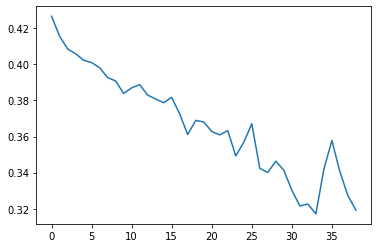

In [42]:
# 그래프로 손실 확인하기
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

### 8. 음표 생성

In [43]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:

  assert temperature > 0

  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [44]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [45]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,60,0.206854,0.299049,0.206854,0.505903
1,70,0.000000,0.468209,0.206854,0.675063
2,95,0.000000,0.471422,0.206854,0.678275
3,64,0.000000,0.490237,0.206854,0.697091
4,95,0.000000,0.405845,0.206854,0.612698
5,93,0.000000,0.470588,0.206854,0.677442
6,91,0.000000,0.480619,0.206854,0.687472
7,96,0.000000,0.474255,0.206854,0.681109
8,100,0.000000,0.549433,0.206854,0.756287
9,96,0.000000,0.528358,0.206854,0.735212


In [46]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
# 음성파일 재생
display_audio(out_pm)

In [47]:
# 오디오 파일 다운로드
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

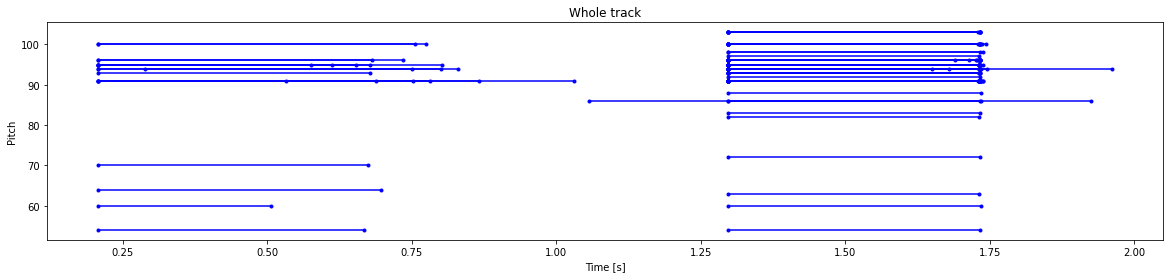

In [48]:
# 생성된 음표 시각화
plot_piano_roll(generated_notes)

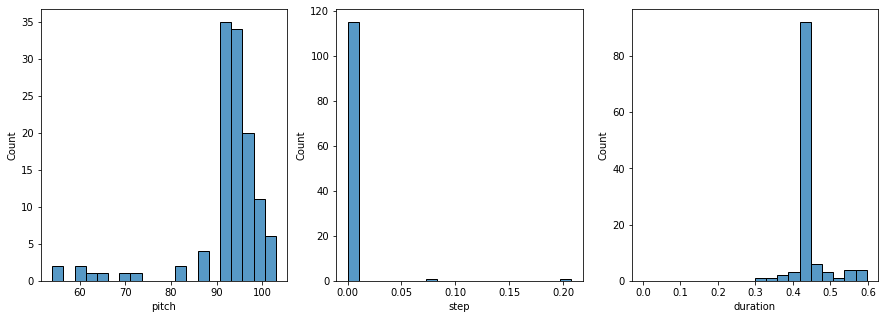

In [49]:
# pitch, step, duration의 분포 확인
plot_distributions(generated_notes)